# AAFC Cropland Classification Using Deep Learning

Here, we will design an image classification pipeline for the AAFC cropland dataset. The dataset contains 6646 satellite images retrieved from Sentinel-2A using the Google Earth Engine tool. The dataset contains image patches of four types of cropland (barley, corn, pasture and mixed wood) from 5 different time periods in the year 2019 (june, july, august, september, october).  

In [1]:
from datetime import datetime
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator # we will be using the images directly from the directories
import os 

## Convolutional Neural Networks

Convolutional neural networks take advantage of the spatial patterns organized within an image. A CNN is composed of CONV and POOl layers primarily. The CONV layers learn specific filters that help extract key features without having to design these features ourselves. The POOL layers perform dimensionality reduction on the image after every set of convolutions. In the context of image classification, our CNN may learn to detect features like edges, shapes, textures or patterns, or even higher-level features like spatial patterns in the higher layers of the network. The very last layer is a classifier that uses these higher-level features to make predictions regarding the contents of the image.

In practice, CNNs give us two key benefits: local invariance and compositionality.

#### Load the dataset


# we will be working with the RGB image directory

In [2]:
# we will be working with the PSRI image directory
train_data_dir = '../AAFC_dataset/ALL_classes/filtered/PSRI/training'
validation_data_dir = '../AAFC_dataset/ALL_classes/filtered/PSRI/validation'
test_data_dir = '../AAFC_dataset/ALL_classes/filtered/PSRI/test'

In [3]:
# create a helper function to count the number of files in each directory 
def number_of_files(dirname):
    cpt = sum([len(files) for r, d, files in os.walk(dirname)])
    return cpt

nb_train_samples=number_of_files(train_data_dir)
nb_validation_samples=number_of_files(validation_data_dir)
nb_test_samples=number_of_files(test_data_dir)

print("Number of training samples: " , nb_train_samples)
print("Number of validation samples: " , nb_validation_samples)
print("Number of test samples: " , nb_test_samples)

Number of training samples:  12120
Number of validation samples:  2609
Number of test samples:  2586


In [4]:
# Define the image dimensions and other training parameters
img_width, img_height, channels  = 64, 64, 3
number_of_classes = 10
class_labels = ["Barley", "Corn", "Millet", "Mixedwood", "Oat", "Orchard", "Pasture", "Potato", "Sorghum", "Soybean"]

# training parameters
epochs = 30
batch_size = 32

steps_per_epoch = nb_train_samples//batch_size
print("Training steps per epoch: ", steps_per_epoch)
validation_steps = nb_validation_samples//batch_size
print("Validation steps per epoch: ", validation_steps)

Training steps per epoch:  378
Validation steps per epoch:  81


### Training a simple 3 layer CONV-Net
We will first train a simple CONV net as a baseline, and see if this model can successfully classify our four image categories. 

#### Build the model architecture

In [5]:
# Build the CNN 
CNN_model = models.Sequential()
CNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Dropout(0.25))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Dropout(0.25))
CNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(layers.MaxPooling2D((2, 2)))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dropout(0.5))
CNN_model.add(layers.Dense(128, activation ="relu"))
CNN_model.add(layers.Dense(10, activation="softmax"))
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [6]:
# compile the model 
CNN_model .compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
             metrics =["accuracy"])

In [7]:
# create the generators for the training, validation and test sets
train_datagen = ImageDataGenerator(rescale = 1./255) # Normalize the images 
test_datagen = ImageDataGenerator(rescale = 1./255) 

# training 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

# validation
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    shuffle = False,
    batch_size=batch_size,
    class_mode='categorical')

# test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 12120 images belonging to 10 classes.
Found 2609 images belonging to 10 classes.
Found 2586 images belonging to 10 classes.


In [8]:
# Train the model 
CNN_history = CNN_model.fit_generator(train_generator,
                                      steps_per_epoch=steps_per_epoch, 
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
378/378 [==============================] - 50s 132ms/step - loss: 1.8705 - accuracy: 0.2887 - val_loss: 1.6980 - val_accuracy: 0.3762
Epoch 2/30
378/378 [==============================] - 43s 115ms/step - loss: 1.6605 - accuracy: 0.3767 - val_loss: 1.6511 - val_accuracy: 0.3854
Epoch 3/30
378/378 [==============================] - 39s 104ms/step - loss: 1.5804 - accuracy: 0.4131 - val_loss: 1.6905 - val_accuracy: 0.3816
Epoch 4/30
378/378 [==============================] - 38s 100ms/step - loss: 1.5190 - accuracy: 0.4298 - val_loss: 1.5243 - val_accuracy: 0.4387
Epoch 5/30
378/378 [==============================] - 42s 110ms/step - loss: 1.4733 - accuracy: 0.4524 - val_loss: 1.5776 - val_accuracy: 0.4209
Epoch 6/30
378/378 [==============================] - 40s 105ms/step - loss: 1.4364 - accuracy: 0.4685 - val_loss: 1.4833 - val_accuracy: 0.4572
Epoch 7/30
378/378 [==============================] - 

In [9]:
dateTimeObj = datetime.now().strftime("%d%b%Y-%Hh%Mm%S")
#print(dateTimeObj)

subset = train_data_dir.split("/")[-2]
print("Subset name: ", subset)

# save the model 
CNN_model.save("CNN-AAFC-" + subset + "-" + str(dateTimeObj) + ".h5")

Subset name:  PSRI


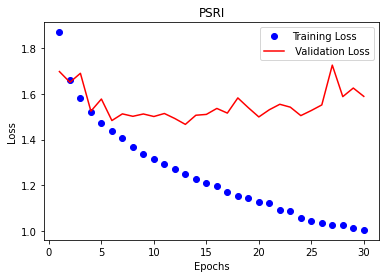

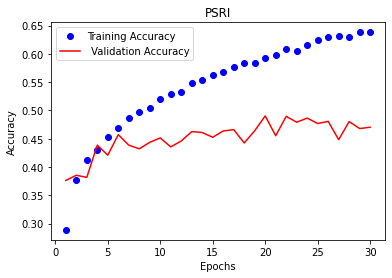

In [10]:
# Plot the training results
import matplotlib.pyplot as plt 

# Visualize the and accuracy loss during training 
history_dict = CNN_history.history

training_loss = history_dict["loss"]
training_accuracy = history_dict["accuracy"]

validation_accuracy = history_dict["val_accuracy"]
validation_loss = history_dict["val_loss"]

epochs = range(1, len(training_loss)+1) 

# Plot the train/val loss
plt.plot(epochs, training_loss, 'bo', label="Training Loss")
plt.plot(epochs, validation_loss, 'r', label=" Validation Loss")

plt.title(subset)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()

# Plot the train/val accuracy
plt.plot(epochs, training_accuracy, 'bo', label="Training Accuracy")
plt.plot(epochs, validation_accuracy, 'r', label=" Validation Accuracy")

plt.title(subset)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
import sys
!python -m pip install --upgrade pip
!pip install pydot
!pip install graphviz

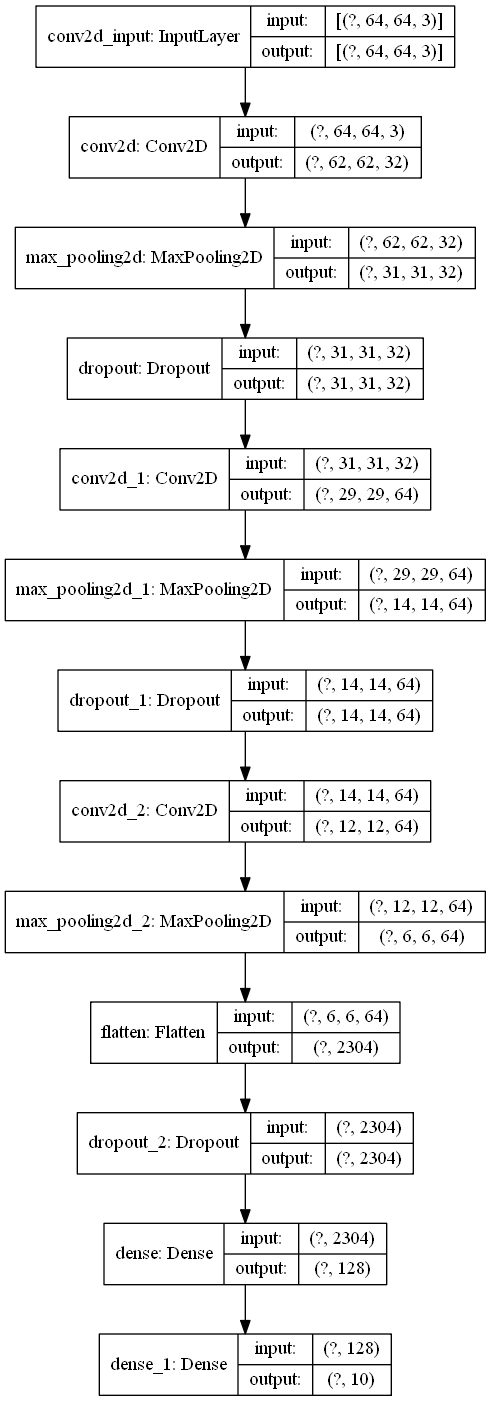

In [12]:
from keras.utils import plot_model
plot_model(CNN_model,
    to_file="CNN_model3.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = CNN_model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print(" ")

print('Classification Report')
print(" ")
target_names = class_labels
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
print(" ")

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[ 18   8   1  11  46   3  13  23   2  67]
 [  2  82   1  47  33   3  29  31   0  35]
 [  3   2   2   4   9   2   2   4   0   8]
 [  1   4   1 157  12   1   2   7   0   7]
 [ 18  14   2  41 169   9  31  30   3 109]
 [  1   2   1   0   3 234   1  13   1   2]
 [  8  19   4  24  40   1  90  31   1  25]
 [  3   9   3  13  44   5  12 276   3  99]
 [  0   0   3   0   5   3   0   1   1   2]
 [ 13  32   3  46  89   2  62  75   1 194]]
 
Classification Report
 
              precision    recall  f1-score   support

      Barley       0.27      0.09      0.14       192
        Corn       0.48      0.31      0.38       263
      Millet       0.10      0.06      0.07        36
   Mixedwood       0.46      0.82      0.59       192
         Oat       0.38      0.40      0.39       426
     Orchard       0.89      0.91      0.90       258
     Pasture       0.37      0.37      0.37       243
      Potato 

In [14]:
#Confution Matrix and Classification Report
print("TEST DATA CONFUSION MATRIX")
Y_pred = CNN_model.predict_generator(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print(" ")

print('Classification Report')
print(" ")
target_names = class_labels
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
print(" ")

TEST DATA CONFUSION MATRIX
Confusion Matrix
[[ 13  13   0  18  52   3  18  27   1  63]
 [  5  73   0  35  24   3  22  17   0  20]
 [  2   1   2   2  15   1   6   6   1   4]
 [  1   5   4 179  16   5   2  17   1  10]
 [ 14  10   1  43 140   6  30  28   4 104]
 [  0   3   1   4   9 217   4  13   0   2]
 [  5  19   3  18  56   7 111  20   0  30]
 [  1  11   4  22  43   3  22 255   1  85]
 [  1   0   0   0   1   1   1   7   1   8]
 [ 20  51   1  38  99   3  64  70   1 183]]
 
Classification Report
 
              precision    recall  f1-score   support

      Barley       0.21      0.06      0.10       208
        Corn       0.39      0.37      0.38       199
      Millet       0.12      0.05      0.07        40
   Mixedwood       0.50      0.75      0.60       240
         Oat       0.31      0.37      0.34       380
     Orchard       0.87      0.86      0.86       253
     Pasture       0.40      0.41      0.40       269
      Potato       0.55      0.57      0.56       447
     Sorghum